# 预测建模
北京市空气质量指数预测（推荐难度系数10）

这个数据集是北京市2022年11月1日至2023年10月31日期间空气质量相关数据。
根据这个数据集，回答以下问题

In [18]:
#导入基础包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#导入主成分分析相关包
from factor_analyzer import Rotator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

#导入XGBOOST相关包
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from matplotlib.dates import DateFormatter, HourLocator

#导入单独写的函数
from calculate import *
from heatmap import *
from sort_matrix import *

In [19]:
#设置字体
plt.rcParams['font.family'] = 'SimHei'
#读取数据
data=pd.read_excel('北京市空气质量指数与气象数据.xlsx')
data.head()

date  hour        AQI        CO        NO2         O3       PM10  \
0 2022-11-01     2  18.371429  0.211429  23.771429  29.057143  13.257143   
1 2022-11-01     5  21.914286  0.180000  26.571429  20.142857  18.914286   
2 2022-11-01     8  28.628571  0.311429  30.028571  14.285714  27.942857   
3 2022-11-01    11  19.000000  0.237143  17.971429  40.529412  17.852941   
4 2022-11-01    14  21.742857  0.252941  15.588235  53.617647  20.941176   

      PM2.5       SO2     T  ...      P   Pa     U   Ff   Tn    Tx    VV   Td  \
0  3.057143  2.628571   6.7  ...  770.5  0.1  36.0  1.0  5.3  17.3  30.0 -7.3   
1  3.771429  2.542857   2.0  ...  770.8  0.3  62.0  0.0  1.9  17.3   7.0 -4.5   
2  6.857143  2.400000   6.6  ...  771.7  0.9  56.0  0.0  0.9  17.3  10.0 -7.1   
3  5.914286  2.176471  13.5  ...  771.3 -0.4  19.0  2.0  0.9  17.3  30.0 -9.7   
4  6.742857  2.000000  15.7  ...  768.6 -2.7  19.0  2.0  0.9  17.3  30.0 -7.9   

   RRR  tR  
0  0.0  12  
1  0.0  12  
2  0.0  12  
3  0.0  12  
4  0.0  12  

[5 rows x 21 columns]

## 题目1
研究单日内空气质量指数与各项指标的变化趋势，这种趋势是否具有周期性？

In [20]:
#数据预处理：将数据按小时分组，计算每个小时各指标的平均值

#可视化：绘制各指标小时均值的折线图，观察是否存在规律性波动


In [21]:
#ACF检验周期性


## 题目2
简述各项指标间的相互关系。

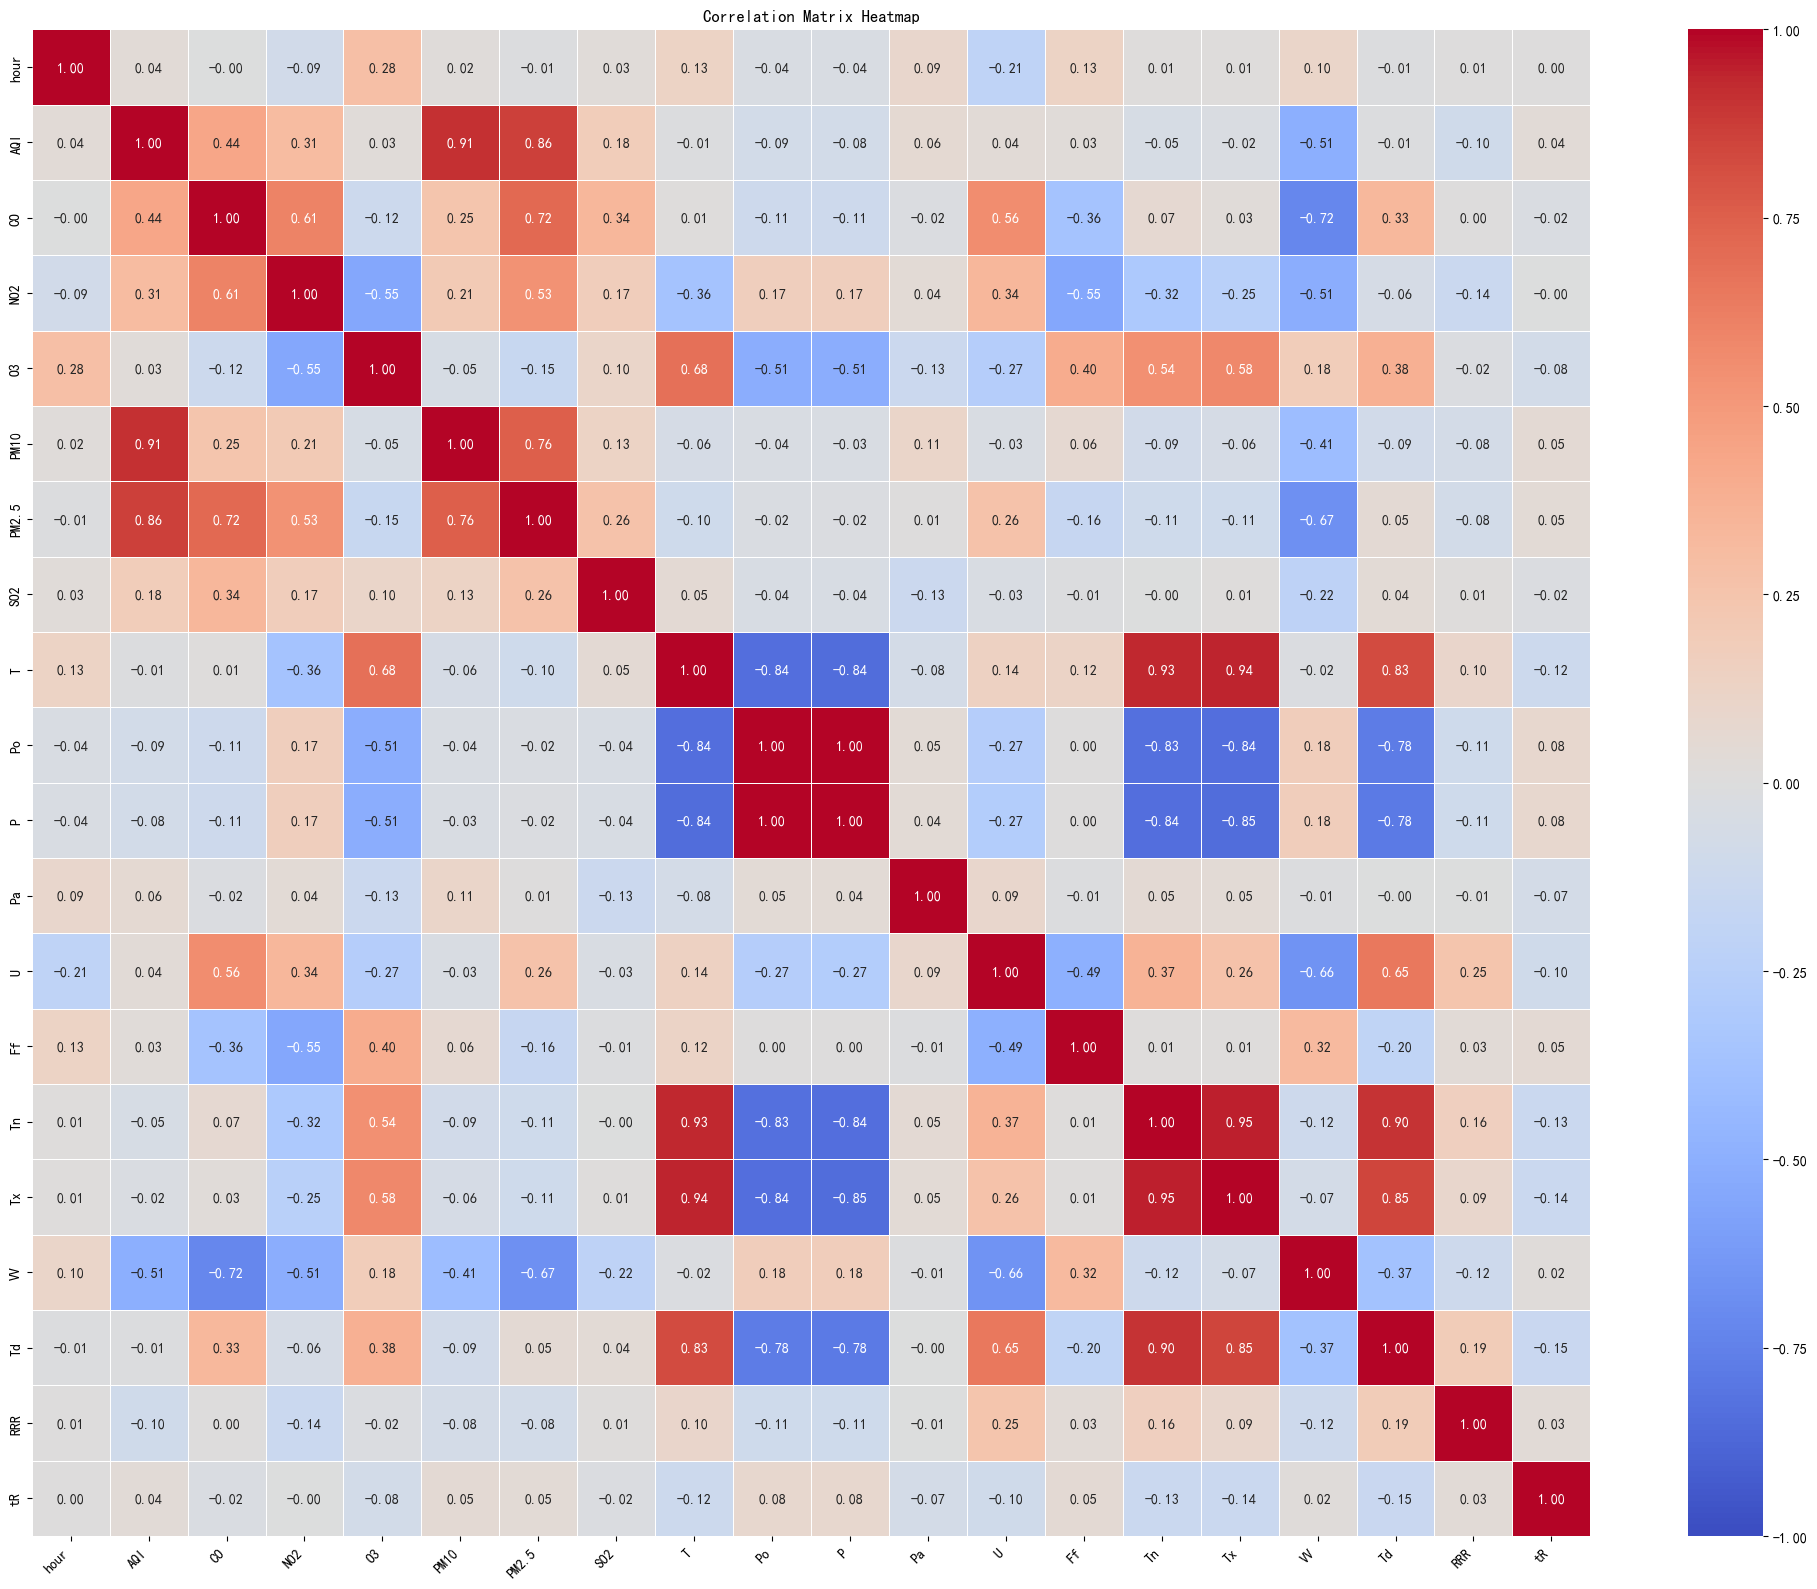

In [22]:
#计算相关系数矩阵
correlation_matrix = data.iloc[:, 1:].corr()
#绘制热力图
plot_heatmap(correlation_matrix,20,16,title="Correlation Matrix Heatmap",save_path="correlation_heatmap.png")

KMO值: 0.762
巴赫利特检验卡方值: 90424.712, p值: 0.0
数据适合进行主成分分析 

累计方差解释比例: ['31.41%', '54.60%', '66.53%', '73.02%', '78.89%', '84.04%', '88.27%', '91.46%', '93.59%', '95.70%', '97.14%', '98.29%', '98.91%', '99.26%', '99.55%', '99.79%', '99.96%', '100.00%', '100.00%']


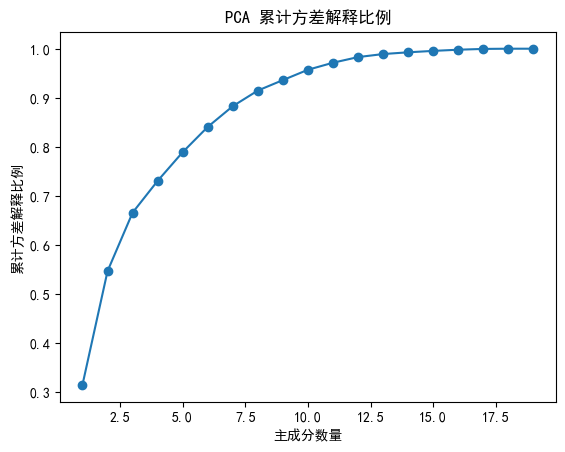

旋转后的载荷矩阵（排序后）：
        Factor1  Factor3  Factor2  Factor4  Factor5
Tn      -0.963   -0.035   -0.071   -0.079    0.035
T       -0.958    0.138   -0.033    0.074   -0.028
Tx      -0.954    0.014   -0.045   -0.052   -0.063
P        0.924    0.029   -0.071   -0.032   -0.000
Po       0.921    0.029   -0.073   -0.033   -0.000
Td      -0.898   -0.366   -0.043   -0.013    0.076
O3      -0.637    0.529    0.030    0.239   -0.084
U       -0.322   -0.824    0.008   -0.156    0.229
Ff      -0.045    0.772    0.126    0.024    0.172
NO2      0.300   -0.728    0.290    0.110   -0.202
CO      -0.101   -0.695    0.449    0.298   -0.007
VV       0.153    0.667   -0.531   -0.093   -0.175
AQI     -0.017   -0.038    0.967    0.025   -0.029
PM10     0.037    0.060    0.933   -0.092    0.003
PM2.5    0.049   -0.359    0.879    0.149   -0.007
Pa       0.006   -0.055    0.147   -0.747   -0.130
SO2     -0.035   -0.099    0.208    0.694   -0.065
RRR     -0.139   -0.094   -0.103   -0.077    0.819
tR       0.163 

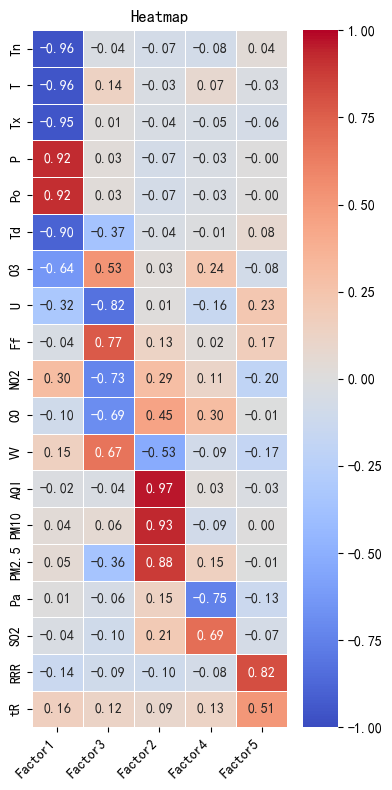

In [23]:
#主成分分析（PCA)
PCA_data=data.iloc[:,2:]#去除日期列

# 计算KMO值
kmo_all, kmo_model = calculate_kmo(PCA_data)
print(f"KMO值: {kmo_model.round(3)}")
# 进行巴赫利特检验
chi_square_value, p_value = calculate_bartlett_sphericity(PCA_data)
print(f"巴赫利特检验卡方值: {chi_square_value.round(3)}, p值: {p_value}")
#判断
if kmo_model>0.7 and p_value<0.05:
    print("数据适合进行主成分分析",'\n')
else:
    print("数据不适合进行主成分分析",'\n')

# 数据标准化
scaled_data = (PCA_data - PCA_data.mean()) / PCA_data.std()
scaled_data = scaled_data.dropna()#去除空值

# 计算协方差矩阵
cov_matrix = np.cov(scaled_data, rowvar=False)

# 计算特征值和特征向量
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# 绘制累计方差解释比例图
explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("累计方差解释比例:", [f"{cum * 100:.2f}%" for cum in cumulative_explained_variance])

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('主成分数量')
plt.ylabel('累计方差解释比例')
plt.title('PCA 累计方差解释比例')
plt.show()

# 选择特征值大于1的作为主成分
mask = sorted_eigenvalues > 1
selected_eigenvectors = sorted_eigenvectors[:, mask]

# 计算因子载荷矩阵
loadings = selected_eigenvectors * np.sqrt(sorted_eigenvalues[mask])

# 使用Varimax旋转载荷矩阵
rotator = Rotator(method='varimax')
rotated_loadings = rotator.fit_transform(loadings)

# 输出旋转后的成分矩阵
rotated_components_df = pd.DataFrame(rotated_loadings,
                                     index=PCA_data.columns,
                                     columns=[f'Factor{i+1}' for i in range(rotated_loadings.shape[1])])
rotated_components_df = rotated_components_df.round(3)

# 输出排序后的载荷矩阵
rotated_components_df=sort_matrix_by_diag(rotated_components_df)
print("旋转后的载荷矩阵（排序后）：\n", rotated_components_df)
plot_heatmap(rotated_components_df, 4, 8,save_path="components_heatmap.png")

## 题目3
令2022年11月1日至2023年9月30日的空气质量数据为训练集，剩余数据为测试集。基于训练集，尝试使用两种不同的方法构建空气质量指数预测模型，并在测试集上测试。比较所选模型的预测效果。

In [24]:
#重新读取数据
data=pd.read_excel('北京市空气质量指数与气象数据.xlsx')
# 合并 date 和 hour 为新的 data_hour 列
data['data_hour'] = pd.to_datetime(data['date']) + pd.to_timedelta(data['hour'], unit='h')
# 设置 data_hour 为索引列
data = data[['data_hour', 'AQI']].set_index('data_hour')  # 仅保留时间和AQI

### (1)SARIMA模型

In [25]:
"""
该模型在假设不知道测试集其他指标的情况下，仅使用AQI历史数据预测未来AQI
"""

#训练模型

#输出预测与实际AQI的对比图

#计算拟合度


'\n该模型在假设不知道测试集其他指标的情况下，仅使用AQI历史数据预测未来AQI\n'

### (2)XGBOOST模型

In [26]:
"""
该模型在假设不考虑测试集其他指标的情况下，仅使用AQI数据对未来AQI进行<单步预测>，即每次预测都是根据之前时间点的真实AQI值进行的。
整体运行时间约为20s，请耐心等待。
"""
#特征工程
data_processed = data.copy()

#时间分解特征
# 基础特征
data_processed['hour'] = data_processed.index.hour
data_processed['day_of_week'] = data_processed.index.dayofweek
data_processed['month'] = data_processed.index.month

# 周期性编码
data_processed['hour_sin'] = np.sin(2 * np.pi * data_processed['hour'] / 24)
data_processed['hour_cos'] = np.cos(2 * np.pi * data_processed['hour'] / 24)
data_processed['week_sin'] = np.sin(2 * np.pi * data_processed['day_of_week'] / 7)
data_processed['week_cos'] = np.cos(2 * np.pi * data_processed['day_of_week'] / 7)

#滞后特征
# 生成3小时粒度的滞后特征（最多7天）
lags = [i for i in range(1, 7 * 8 + 1)]  # 7天*每天8个时间点（3小时间隔）
for lag in lags:
    data_processed[f'AQI_lag_{lag}'] = data_processed['AQI'].shift(lag)

# 划分数据集
train_data = data_processed.loc['2022-11-01':'2023-09-30']
test_data = data_processed.loc['2023-10-01':]

# 特征选择
features = [col for col in train_data.columns if col != 'AQI']
X_train, y_train = train_data[features], train_data['AQI']
X_test, y_test = test_data[features], test_data['AQI']

In [27]:
#随机搜索法参数调优（这里耗时较长，请耐心等待）
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': randint(5, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.3)
}

search = RandomizedSearchCV(
    XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1
)
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EB86B7EC90>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EBFF5165D0>,
                                        'n_estimators': [100, 200, 300],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EB86A1C5F0>},
                   scoring='neg_mean_absolute_error', verbose=1)

In [28]:
#模型预测
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
#评估指标
metrics=cal_metrics(y_pred, y_test)
#输出结果
print("最佳参数组合：", search.best_params_)
print("评估指标：")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")

最佳参数组合： {'colsample_bytree': 0.7508184716426058, 'gamma': 0.020833743645897518, 'learning_rate': 0.05075327204554973, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8259294864645319}
评估指标：
RMSE: 12.30
R-squared: 0.92
MAE: 7.87


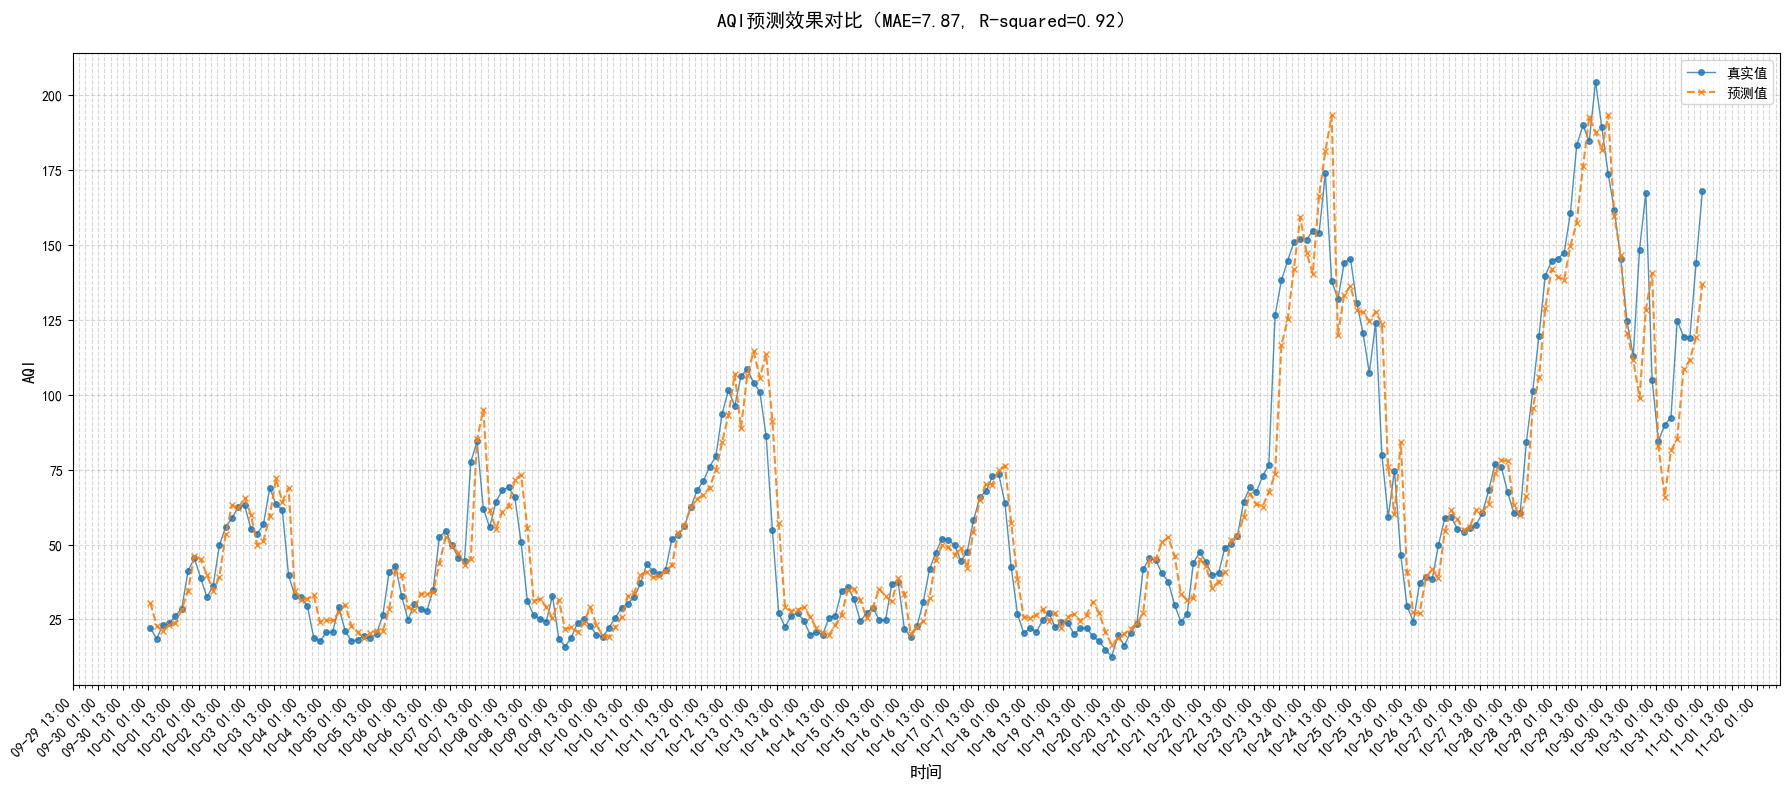

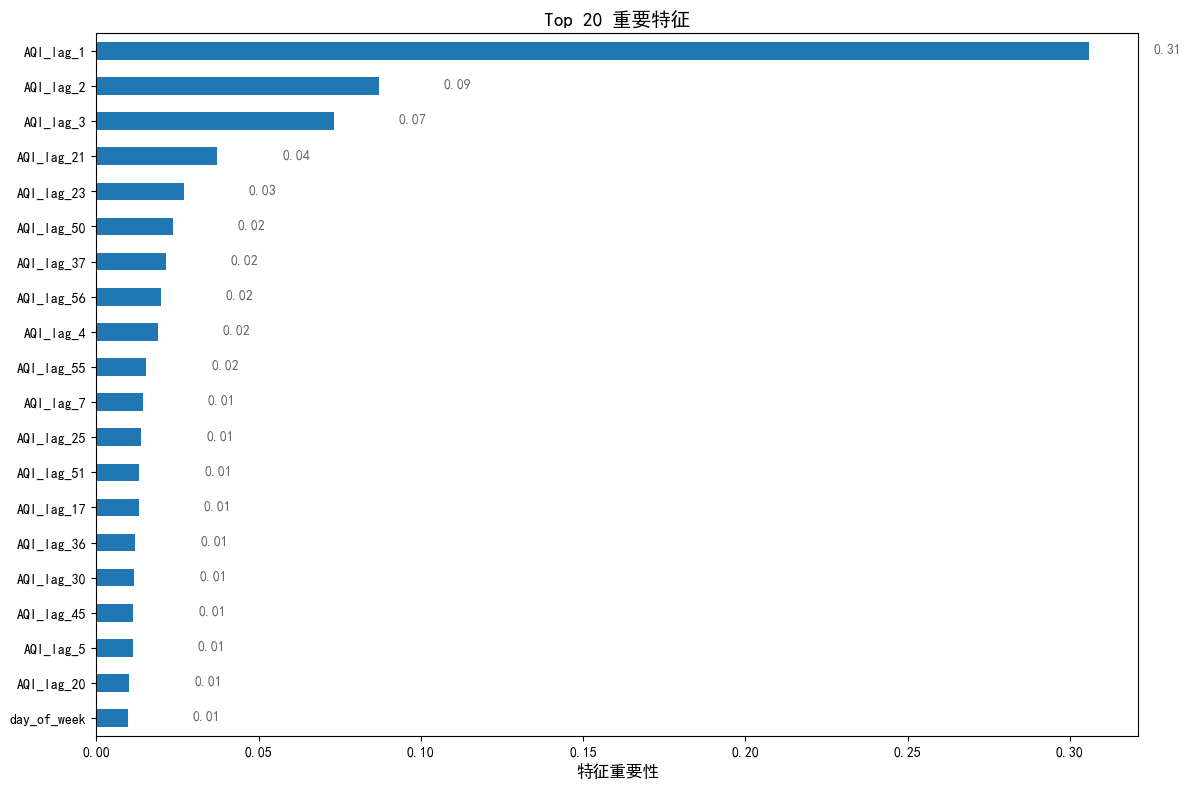

In [29]:
#预测结果可视化
def plot_results(y_true, y_pred, timestamps):
    plt.figure(figsize=(18, 8))
    ax = plt.gca()

    # 绘制预测曲线
    ax.plot(timestamps, y_true, label='真实值',
            marker='o', markersize=4, linewidth=1, alpha=0.8)
    ax.plot(timestamps, y_pred, label='预测值',
            linestyle='--', marker='x', markersize=5, alpha=0.9)

    # 设置时间轴格式
    ax.xaxis.set_major_locator(HourLocator(interval=12))
    ax.xaxis.set_minor_locator(HourLocator(interval=3))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H:%M"))

    # 增强可视化元素
    plt.title(f'AQI预测效果对比（MAE={metrics["MAE"]:.2f}, R-squared={metrics["R-squared"]:.2f}）',
              fontsize=14, pad=20)
    plt.xlabel('时间', fontsize=12)
    plt.ylabel('AQI', fontsize=12)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()

    # 自动调整标签
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_results(y_test, y_pred, test_data.index)

#特征重要性可视化
def plot_importance(model, features, top_n=20):
    importance = pd.Series(model.feature_importances_, index=features)
    top_features = importance.sort_values(ascending=False)[:top_n]

    plt.figure(figsize=(12, 8))
    ax = top_features.sort_values().plot.barh()

    # 添加数据标签
    for i in ax.patches:
        ax.text(i.get_width() + 0.02, i.get_y() + 0.2,
                f'{i.get_width():.2f}',
                fontsize=10, color='dimgrey')

    plt.title('Top {} 重要特征'.format(top_n), fontsize=14)
    plt.xlabel('特征重要性', fontsize=12)
    plt.tight_layout()
    plt.show()


plot_importance(best_model, features)